# Dev

In [1]:
# load and plot
import numpy as np
import matplotlib.pyplot as plt
from pynwb import NWBHDF5IO
from pathlib import Path
import pandas as pd
from typing import Union
import json
import file_handling

# reload
%matplotlib inline
%reload_ext autoreload
%autoreload 2

output_path = "../results/"

In [ ]:
# good autoreward session
#multiplane-ophys_739564_2024-08-26_14-35-58_processed_2024-08-28_21-48-36
#960c0c20-5d00-4378-bac0-6a585e123f9c

# Make NWB

In [2]:
processed_path  = "../data/multiplane-ophys_739564_2024-08-26_14-35-58_processed_2024-08-28_21-48-36"
file_handling.get_multiplane_processed_file_paths(processed_path)

{'planes': {'VISp_0': {'processing_json': PosixPath('../data/multiplane-ophys_739564_2024-08-26_14-35-58_processed_2024-08-28_21-48-36/VISp_0/decrosstalk/processing.json'),
   'params_json': PosixPath('../data/multiplane-ophys_739564_2024-08-26_14-35-58_processed_2024-08-28_21-48-36/VISp_0/events/VISp_0_params.json'),
   'registered_metrics_json': None,
   'average_projection_png': PosixPath('../data/multiplane-ophys_739564_2024-08-26_14-35-58_processed_2024-08-28_21-48-36/VISp_0/motion_correction/VISp_0_average_projection.png'),
   'max_projection_png': PosixPath('../data/multiplane-ophys_739564_2024-08-26_14-35-58_processed_2024-08-28_21-48-36/VISp_0/motion_correction/VISp_0_maximum_projection.png'),
   'motion_transform_csv': PosixPath('../data/multiplane-ophys_739564_2024-08-26_14-35-58_processed_2024-08-28_21-48-36/VISp_0/motion_correction/VISp_0_motion_transform.csv'),
   'segmentation_output_json': PosixPath('../data/multiplane-ophys_739564_2024-08-26_14-35-58_processed_2024-08-

In [39]:
seg_json = "/home/matt.davis/code/aind-ophys-nwb/data/multiplane-ophys_739564_2024-08-26_14-35-58_processed_2024-08-28_21-48-36/VISp_0/segmentation/VISp_0_segmentation_output.json"

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Load the JSON file
seg_data = pd.DataFrame(load_json(seg_json))

seg_data.


,x,y,width,height,mask_matrix,valid_roi,mask_image_plane,exclusion_labels,id,max_correction_up,max_correction_down,max_correction_left,max_correction_right
0,187,8,18,17,"[[False, False, False, False, False, False, Fa...",True,0,[],0,0,0,0,0
1,19,10,18,16,"[[False, False, False, False, False, False, Fa...",True,0,[],1,0,0,0,0
2,460,38,16,16,"[[False, False, True, True, True, True, True, ...",True,0,[],2,0,0,0,0
3,278,39,17,17,"[[False, False, False, False, False, True, Tru...",True,0,[],3,0,0,0,0
4,248,42,14,15,"[[False, False, False, False, True, True, True...",True,0,[],4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,33,489,17,14,"[[False, False, False, False, True, False, Fal...",True,0,[],72,0,0,0,0
73,332,491,16,19,"[[False, False, False, False, False, False, Tr...",True,0,[],73,0,0,0,0
74,44,498,15,14,"[[False, False, False, False, False, False, Fa...",True,0,[],74,0,0,0,0
75,117,502,5,5,"[[False, False, True, True, False], [False, Tr...",False,0,[small_size],75,0,0,0,0


# Read NWB

In [4]:
io=NWBHDF5IO(output_path + "ophys.nwb", mode="r")
nwb_open = io.read()
nwb_open


/data/learning/mattd/miniconda3/envs/dev/lib/python3.8/site-packages/pynwb/ophys.py:446: UserWarning: RoiResponseSeries 'all_rois': The second dimension of data does not match the length of rois, but instead the first does. Data is oriented incorrectly and should be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of rois, "


,pixel_mask
id,
0,"[[187, 15, 1.0], [187, 16, 1.0], [187, 17, 1.0], [187, 18, 1.0], [187, 19, 1.0], [187, 20, 1.0], [188, 12, 1.0], [188, 13, 1.0], [188, 14, 1.0], [188, 15, 1.0], [188, 16, 1.0], [188, 17, 1.0], [188, 18, 1.0], [188, 19, 1.0], [188, 20, 1.0], [188, 21, 1.0], [188, 22, 1.0], [189, 11, 1.0], [189, 12, 1.0], [189, 13, 1.0], [189, 14, 1.0], [189, 15, 1.0], [189, 16, 1.0], [189, 17, 1.0], [189, 18, 1.0], [189, 19, 1.0], [189, 20, 1.0], [189, 21, 1.0], [189, 22, 1.0], [189, 23, 1.0], [190, 10, 1.0], [190, 11, 1.0], [190, 12, 1.0], [190, 13, 1.0], [190, 14, 1.0], [190, 15, 1.0], [190, 16, 1.0], [190, 17, 1.0], [190, 18, 1.0], [190, 19, 1.0], [190, 20, 1.0], [190, 21, 1.0], [190, 22, 1.0], [190, 23, 1.0], [190, 24, 1.0], [191, 10, 1.0], [191, 11, 1.0], [191, 12, 1.0], [191, 13, 1.0], [191, 14, 1.0], [191, 15, 1.0], [191, 16, 1.0], [191, 17, 1.0], [191, 18, 1.0], [191, 19, 1.0], [191, 20, 1.0], [191, 21, 1.0], [191, 22, 1.0], [191, 23, 1.0], [191, 24, 1.0], [191, 25, 1.0], [192, 9, 1.0], [192, 10, 1.0], [192, 11, 1.0], [192, 12, 1.0], [192, 13, 1.0], [192, 14, 1.0], [192, 15, 1.0], [192, 16, 1.0], [192, 17, 1.0], [192, 18, 1.0], [192, 19, 1.0], [192, 20, 1.0], [192, 21, 1.0], [192, 22, 1.0], [192, 23, 1.0], [192, 24, 1.0], [193, 9, 1.0], [193, 10, 1.0], [193, 11, 1.0], [193, 12, 1.0], [193, 13, 1.0], [193, 14, 1.0], [193, 15, 1.0], [193, 16, 1.0], [193, 17, 1.0], [193, 18, 1.0], [193, 19, 1.0], [193, 20, 1.0], [193, 21, 1.0], [193, 22, 1.0], [193, 23, 1.0], [193, 24, 1.0], [193, 25, 1.0], [194, 8, 1.0], [194, 9, 1.0], [194, 10, 1.0], [194, 11, 1.0], [194, 12, 1.0], [194, 13, 1.0], ...]"
1,"[[19, 19, 1.0], [20, 13, 1.0], [20, 14, 1.0], [20, 15, 1.0], [20, 16, 1.0], [20, 17, 1.0], [20, 18, 1.0], [20, 19, 1.0], [20, 20, 1.0], [21, 12, 1.0], [21, 13, 1.0], [21, 14, 1.0], [21, 15, 1.0], [21, 16, 1.0], [21, 17, 1.0], [21, 18, 1.0], [21, 19, 1.0], [21, 20, 1.0], [21, 21, 1.0], [22, 11, 1.0], [22, 12, 1.0], [22, 13, 1.0], [22, 14, 1.0], [22, 15, 1.0], [22, 16, 1.0], [22, 17, 1.0], [22, 18, 1.0], [22, 19, 1.0], [22, 20, 1.0], [22, 21, 1.0], [22, 22, 1.0], [23, 11, 1.0], [23, 12, 1.0], [23, 13, 1.0], [23, 14, 1.0], [23, 15, 1.0], [23, 16, 1.0], [23, 17, 1.0], [23, 18, 1.0], [23, 19, 1.0], [23, 20, 1.0], [23, 21, 1.0], [23, 22, 1.0], [23, 23, 1.0], [24, 10, 1.0], [24, 11, 1.0], [24, 12, 1.0], [24, 13, 1.0], [24, 14, 1.0], [24, 15, 1.0], [24, 16, 1.0], [24, 17, 1.0], [24, 18, 1.0], [24, 19, 1.0], [24, 20, 1.0], [24, 21, 1.0], [24, 22, 1.0], [24, 23, 1.0], [24, 24, 1.0], [25, 10, 1.0], [25, 11, 1.0], [25, 12, 1.0], [25, 13, 1.0], [25, 14, 1.0], [25, 15, 1.0], [25, 16, 1.0], [25, 17, 1.0], [25, 18, 1.0], [25, 19, 1.0], [25, 20, 1.0], [25, 21, 1.0], [25, 22, 1.0], [25, 23, 1.0], [25, 24, 1.0], [25, 25, 1.0], [26, 10, 1.0], [26, 11, 1.0], [26, 12, 1.0], [26, 13, 1.0], [26, 14, 1.0], [26, 15, 1.0], [26, 16, 1.0], [26, 17, 1.0], [26, 18, 1.0], [26, 19, 1.0], [26, 20, 1.0], [26, 21, 1.0], [26, 22, 1.0], [26, 23, 1.0], [26, 24, 1.0], [26, 25, 1.0], [26, 26, 1.0], [27, 10, 1.0], [27, 11, 1.0], [27, 12, 1.0], [27, 13, 1.0], [27, 14, 1.0], [27, 15, 1.0], [27, 16, 1.0], [27, 17, 1.0], ...]"
2,"[[460, 40, 1.0], [460, 41, 1.0], [460, 42, 1.0], [460, 43, 1.0], [460, 44, 1.0], [460, 45, 1.0], [460, 46, 1.0], [460, 47, 1.0], [461, 39, 1.0], [461, 40, 1.0], [461, 41, 1.0], [461, 42, 1.0], [461, 43, 1.0], [461, 44, 1.0], [461, 45, 1.0], [461, 46, 1.0], [461, 47, 1.0], [461, 48, 1.0], [462, 38, 1.0], [462, 39, 1.0], [462, 40, 1.0], [462, 41, 1.0], [462, 42, 1.0], [462, 43, 1.0], [462, 44, 1.0], [462, 45, 1.0], [462, 46, 1.0], [462, 47, 1.0], [462, 48, 1.0], [462, 49, 1.0], [463, 38, 1.0], [463, 39, 1.0], [463, 40, 1.0], [463, 41, 1.0], [463, 42, 1.0], [463, 43, 1.0], [463, 44, 1.0], [463, 45, 1.0], [463, 46, 1.0], [463, 47, 1.0], [463, 48, 1.0], [463, 49, 1.0], [463, 50, 1.0], [464, 38, 1.0], [464, 39, 1.0], [464, 40, 1.0], [464, 41, 1.0], [464, 42, 1.0], [464, 43, 1.0], [464, 44, 1.0], [464, 45, 1.0], [464, 46, 1.0], [464, 47, 1.0], [464, 48, 1.0], 

In [31]:
with NWBHDF5IO(output_path + "ophys.nwb", "r") as io:
    read_nwb = io.read()
    plane_names = read_nwb.processing.keys()
    dff = read_nwb.processing[plane]["DfOverF"]["all_rois"].data[:]
    rois_table = read_nwb.processing[plane]["DfOverF"]["all_rois"].rois[:]
    avg = read_nwb.processing[plane]['summary_images']['average_projection'].data[:]
print(plane_names)

plane = list(plane_names)[0]

/data/learning/mattd/miniconda3/envs/dev/lib/python3.8/site-packages/pynwb/ophys.py:446: UserWarning: RoiResponseSeries 'all_rois': The second dimension of data does not match the length of rois, but instead the first does. Data is oriented incorrectly and should be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of rois, "


dict_keys(['ophys_plane_VISp_0', 'ophys_plane_VISp_1', 'ophys_plane_VISp_2', 'ophys_plane_VISp_3', 'ophys_plane_VISp_4', 'ophys_plane_VISp_5', 'ophys_plane_VISp_6', 'ophys_plane_VISp_7'])


In [7]:
plt.imshow(avg, cmap='gray')

NameError: name 'avg' is not defined

In [ ]:

with NWBHDF5IO(output_path + "ophys.nwb", "r") as io:
    read_nwbfile = io.read()
    print(read_nwbfile.processing[plane])
    print(read_nwbfile.processing[plane]["DfOverF"])
    print(read_nwbfile.processing[plane]["DfOverF"]["all_rois"])

In [24]:
io.close()

## Check formatting 09/05/2024

### images

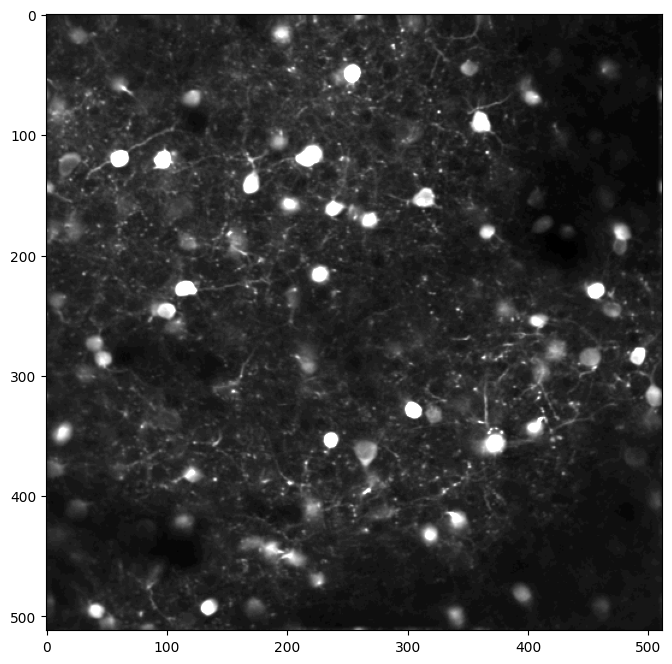

In [29]:
#img = nwb_open.processing[plane]['summary_images']['average_projection'].data[:]

# plot the average image, 10x10 vmax 99 percentile
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray', vmax=np.percentile(img, 99))

## ROIS

In [32]:
#rois_table = nwb_open.processing[plane]["DfOverF"]["all_rois"].rois[:]
rois_table 

,pixel_mask
id,
0,"[[187, 15, 1.0], [187, 16, 1.0], [187, 17, 1.0..."
1,"[[19, 19, 1.0], [20, 13, 1.0], [20, 14, 1.0], ..."
2,"[[460, 40, 1.0], [460, 41, 1.0], [460, 42, 1.0..."
3,"[[278, 44, 1.0], [278, 45, 1.0], [278, 46, 1.0..."
4,"[[248, 46, 1.0], [248, 47, 1.0], [248, 48, 1.0..."
...,...
72,"[[33, 493, 1.0], [33, 496, 1.0], [33, 497, 1.0..."
73,"[[332, 497, 1.0], [332, 498, 1.0], [332, 499, ..."
74,"[[44, 505, 1.0], [44, 506, 1.0], [45, 504, 1.0..."


In [33]:
# one pixel mask
roi_pixel_mask = rois_table.pixel_mask.values[0]
roi_pixel_mask[:4]

array([(187, 15, 1.), (187, 16, 1.), (187, 17, 1.), (187, 18, 1.)],
      dtype=[('x', '<u4'), ('y', '<u4'), ('weight', '<f4')])

### plot pixel masks

Pixels found greather than canvas size (512, 512)
Pixels found greather than canvas size (512, 512)
Pixels found greather than canvas size (512, 512)
Pixels found greather than canvas size (512, 512)


<Axes: >

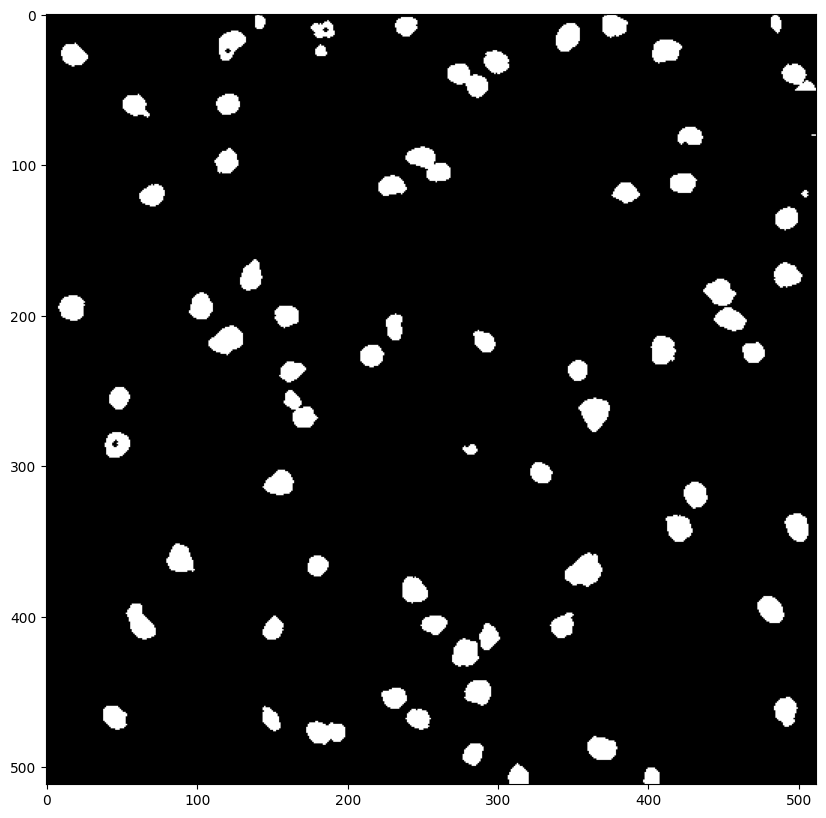

In [34]:
def plot_pixel_masks(pixel_masks: Union[list, pd.DataFrame], 
                     canvas_size: tuple = (512, 512),
                     ax = None) -> plt.Axes:
    """
    Plot pixel masks on a canvas.
    Example pixel mask:
    [(35,  3, 1.), 
     (35,  4, 1.), 
     (35,  5, 1.)]
    
    """
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(10, 10))

    if isinstance(pixel_masks, pd.DataFrame):
        assert 'pixel_mask' in pixel_masks.columns
        pixel_masks = rois_table.pixel_mask.values

    canvas = np.zeros(canvas_size)
    for pixel_mask in pixel_masks:
        try:
            for x,y,z in pixel_mask:
                canvas[x,y] = z
        except:
            # warn that some pixels greater than canvas size
            print(f"Pixels found greather than canvas size {canvas_size}")
            continue

    ax.imshow(canvas, 
                cmap='gray', 
                interpolation=None)
    return ax

plot_pixel_masks(rois_table, canvas_size=(512, 512))

Error
Error
Error
Error


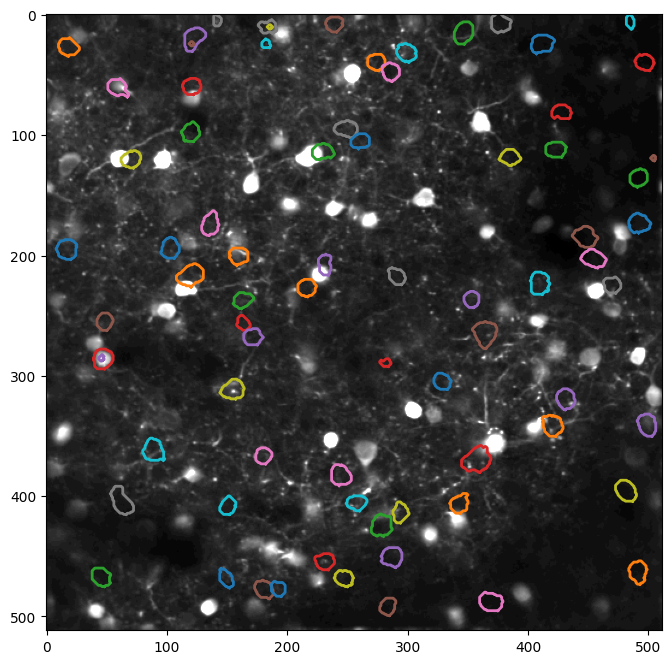

In [35]:
# plot contours for each roi
import skimage

fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img, cmap='gray', vmax=np.percentile(img, 99))

for pixel_mask in rois_table.pixel_mask:
    try:
        mask = np.zeros((512, 512))
        for x,y,z in pixel_mask:
            mask[x,y] = z
        contours = skimage.measure.find_contours(mask, 0.8)
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    except:
        print("Error")
        #print(pixel_mask)

In [18]:
#p

import matplotlib.pyplot as plt
from typing import List, Union

def plot_pixel_masks_return_errors(pixel_masks: Union[list, pd.DataFrame], 
                     canvas_size: tuple = (512, 512),
                     ax = None) -> plt.Axes:
    """
    Plot pixel masks on a canvas.
    Example pixel mask:
    [(35,  3, 1.), 
     (35,  4, 1.), 
     (35,  5, 1.)]
    
    """
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(10, 10))

    if isinstance(pixel_masks, pd.DataFrame):
        assert 'pixel_mask' in pixel_masks.columns
        pixel_masks = rois_table.pixel_mask.values

    canvas = np.zeros(canvas_size)
    error_canvas = np.zeros((600, 600))
    for pixel_mask in pixel_masks:
        #print(pixel_mask)
        try:
            for x,y,z in pixel_mask:
                canvas[x,y] = z
        except:
            print()
            print("Error >512")
            print(pixel_mask)
            for x,y,z in pixel_mask:
                #if x > 511 or y > 511:
                #print(x,y,z)
                error_canvas[x,y] = z
            continue

    ax.imshow(canvas, 
               cmap='gray', 
               interpolation=None)
    return ax, error_canvas



ax, error_canvas = plot_pixel_masks_return_errors(rois_table)

# plot error
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(error_canvas, 
           cmap='viridis', 
           interpolation=None)




# plot dashed red line at 512 and 512
ax.plot([512, 512], [0, 512], 'r--')
ax.plot([0, 512], [512, 512], 'r--')


NameError: name 'rois_table' is not defined

In [17]:
# how many pixels are out of bounds
np.sum(error_canvas)

17.0

In [11]:
for _ in range(30):
    # randomly generate example starting points for region
    x = np.random.randint(0, 95)
    y = np.random.randint(0, 95)

    # define an example 4 x 3 region of pixels of weight '1'
    pixel_mask = []
    for ix in range(x, x + 4):
        for iy in range(y, y + 3):
            pixel_mask.append((ix, iy, 1))

In [31]:
pixel_mask

[(85, 0, 1),
 (85, 1, 1),
 (85, 2, 1),
 (86, 0, 1),
 (86, 1, 1),
 (86, 2, 1),
 (87, 0, 1),
 (87, 1, 1),
 (87, 2, 1),
 (88, 0, 1),
 (88, 1, 1),
 (88, 2, 1)]

### read with

In [ ]:
# with NWBHDF5IO("ophys.nwb", "r") as io:
#     read_nwbfile = io.read()

#     roi_resp_series = read_nwbfile.processing["ophys"]["Fluorescence"][
#         "RoiResponseSeries"
#     ]